This is the Project licensed by Dulguun.B. Kek

Энэхүү прожектоор теннис тоглох хөдөлгөөнийг тодорхойлохын тулд гүн сургалт болон LSTM хослуулан ажиллуулах болно.

Prepare Packages

In [61]:
%pip install -r requirements.txt

^C
Note: you may need to restart the kernel to use updated packages.


  Using cached moviepy-2.1.2-py3-none-any.whl.metadata (6.9 kB)
  Using cached pafy-0.5.5-py2.py3-none-any.whl.metadata (10 kB)
  Using cached youtube_dl-2021.12.17-py2.py3-none-any.whl.metadata (1.5 kB)
  Using cached gdown-4.6.3-py3-none-any.whl.metadata (4.4 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached thop-0.1.1.post2209072238-py3-none-any.whl.metadata (2.7 kB)
  Using cached beautifulsoup4-4.13.4-py3-none-any.whl.metadata (3.8 kB)
  Using cached gast-0.4.0-py3-none-any.whl.metadata (1.1 kB)
  Using cached tensorboard-2.12.3-py3-none-any.whl.metadata (1.8 kB)
  Using cached tensorflow_estimator-2.12.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached keras-2.12.0-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached google_auth-2.40.1-py2.py3-none-any.whl.metadata (6.2 kB)
  Using cached google_auth_oauthlib-1.0.0-py2.py3-none-any.whl.metadata (2.7 kB)
  Using cached cachetools-5.5.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pyasn1

  DEPRECATION: Building 'moviepy' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'moviepy'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'c:\\Users\\Dulguun\\.conda\\envs\\tf_clean\\Lib\\site-packages\\tensorflow\\compiler\\tf2tensorrt\\_pywrap_py_utils.pyd'
Consider using the `--user` option or check the permissions.



Prepare Datas

In [62]:
import os
current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")

Current working directory: c:\Users\Dulguun\Desktop\Workspace\tennis_v0


In [63]:
import cv2
import numpy as np
import os
import tensorflow as tf
import tensorflow_hub as hub
from ultralytics import YOLO
import time
import mediapipe as mp

In [133]:
# Initialize MoveNet
movenet_model = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
movenet = movenet_model.signatures['serving_default']

# Initialize YOLOv8-pose
yolo_model = YOLO("yolov8n-pose.pt")  # Nano model for speed; use yolov8m-pose.pt for better accuracy

# Initialize Mediapipe
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = None
try:
    pose = mp_pose.Pose(static_image_mode=False, model_complexity=1, enable_segmentation=False, min_detection_confidence=0.5)
    print("MediaPipe Pose initialized successfully.")
except Exception as e:
    print(f"Failed to initialize MediaPipe Pose: {e}")
    raise

# Function to process frame with MediaPipe
def process_frame_mediapipe(frame):
    try:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(frame_rgb)
        keypoints = []
        confidence = 0
        if results.pose_landmarks:
            for landmark in results.pose_landmarks.landmark:
                keypoints.extend([landmark.x, landmark.y, landmark.visibility])
            confidence = np.mean([landmark.visibility for landmark in results.pose_landmarks.landmark])
        return np.array(keypoints) if keypoints else np.zeros(33 * 3), confidence, results.pose_landmarks
    except Exception as e:
        print(f"Error in process_frame_mediapipe: {e}")
        raise

# Function to process frame with MoveNet
def process_frame_movenet(frame):
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = tf.image.resize_with_pad(img, 192, 192)
    img = tf.cast(img, dtype=tf.int32)
    img = tf.expand_dims(img, axis=0)
    results = movenet(img)
    keypoints = results['output_0'].numpy()[0, 0, :, :3]  # 17 keypoints (y, x, confidence)
    confidence = np.mean(keypoints[:, 2])
    return keypoints.flatten(), confidence, None  # No landmarks object for drawing

# Function to process frame with YOLOv8
def process_frame_yolo(frame):
    results = yolo_model(frame, verbose=False)[0]
    keypoints = []
    confidence = 0
    if results.keypoints.xy.shape[0] > 0:  # Check if any person detected
        person_keypoints = results.keypoints.xy[0].cpu().numpy()  # (17, 2) for x, y
        person_conf = results.keypoints.conf[0].cpu().numpy()  # (17,) for confidence
        keypoints = []
        for i in range(len(person_keypoints)):
            keypoints.extend([person_keypoints[i, 0] / frame.shape[1],  # Normalize x
                            person_keypoints[i, 1] / frame.shape[0],  # Normalize y
                            person_conf[i]])
        confidence = np.mean(person_conf)
    return np.array(keypoints) if keypoints else np.zeros(17 * 3), confidence, None

# Function to draw keypoints for MoveNet/YOLOv8 (COCO 17-keypoint format)
def draw_keypoints_coco(frame, keypoints, frame_width, frame_height, threshold=0.3):
    connections = [
        (0, 1), (0, 2), (1, 3), (2, 4), (5, 6), (5, 7), (7, 9), (6, 8), (8, 10),
        (5, 11), (6, 12), (11, 12), (11, 13), (13, 15), (12, 14), (14, 16)
    ]
    for i in range(0, len(keypoints), 3):
        x, y, conf = keypoints[i:i+3]
        if conf > threshold:
            cx, cy = int(x * frame_width), int(y * frame_height)
            cv2.circle(frame, (cx, cy), 5, (0, 255, 0), -1)
    for start, end in connections:
        x1, y1, c1 = keypoints[start*3:start*3+3]
        x2, y2, c2 = keypoints[end*3:end*3+3]
        if c1 > threshold and c2 > threshold:
            cv2.line(frame, (int(x1 * frame_width), int(y1 * frame_height)),
                     (int(x2 * frame_width), int(y2 * frame_height)), (0, 0, 255), 2)
    return frame

# Function to process video, extract keypoints, and save video with keypoints
def extract_keypoints(video_path, output_dir, model_type="mediapipe", sequence_length=30, output_video_name="output_with_keypoints.mp4"):
    # Open input video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return [], 0

    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Initialize VideoWriter
    os.makedirs(output_dir, exist_ok=True)
    output_video_path = os.path.join(output_dir, output_video_name)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))
    if not out.isOpened():
        print(f"Error: Could not create output video {output_video_path}")
        cap.release()
        return [], 0

    keypoints_sequence = []
    frame_count = 0
    all_sequences = []
    start_time = time.time()

    try:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Process frame based on model type
            if model_type == "mediapipe":
                keypoints, confidence, landmarks = process_frame_mediapipe(frame)
            elif model_type == "movenet":
                keypoints, confidence, landmarks = process_frame_movenet(frame)
            elif model_type == "yolo":
                keypoints, confidence, landmarks = process_frame_yolo(frame)
            else:
                raise ValueError("Unsupported model_type. Use 'mediapipe', 'movenet', or 'yolo'.")

            if len(keypoints) > 0:
                keypoints_sequence.append(keypoints)

            # Draw keypoints on frame
            if model_type == "mediapipe" and landmarks:
                mp_drawing.draw_landmarks(frame, landmarks, mp_pose.POSE_CONNECTIONS)
            else:
                frame = draw_keypoints_coco(frame, keypoints, frame_width, frame_height)

            # Add text overlays
            cv2.putText(frame, f"Frame: {frame_count}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.putText(frame, f"Confidence: {confidence:.2f}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            # Write frame to output video
            out.write(frame)

            # Visualize
            cv2.imshow(f'{model_type.capitalize()} Pose', frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

            frame_count += 1

            # Create sequences of 30 frames
            if len(keypoints_sequence) == sequence_length:
                all_sequences.append(np.array(keypoints_sequence))
                keypoints_sequence = keypoints_sequence[1:]

    finally:
        # Release resources
        cap.release()
        out.release()
        cv2.destroyAllWindows()
        if model_type == "mediapipe" and pose is not None:
            pose.close()
            print("MediaPipe Pose closed.")

    # Calculate FPS
    elapsed_time = time.time() - start_time
    processing_fps = frame_count / elapsed_time if elapsed_time > 0 else 0

    # Save keypoints sequences
    sequences_path = os.path.join(output_dir, f'keypoints_sequences_{model_type}.npy')
    np.save(sequences_path, np.array(all_sequences))

    print(f"Saved keypoints sequences to {sequences_path}")
    print(f"Saved output video to {output_video_path}")
    print(f"Processing FPS ({model_type}): {processing_fps:.2f}")

    return all_sequences, processing_fps

MediaPipe Pose initialized successfully.


In [134]:
# Define video input
video_name = 'test2.mp4'
video_dir = 'videos'
if not os.path.exists(video_dir):
    os.makedirs(video_dir)
video_path = os.path.join(video_dir, video_name)
if not os.path.exists(video_path):
    print(f"Error: Video file {video_path} not found.")
    exit(1)

print(f"Processing video: {video_path}")

# Define output directory
output_dir = 'keypoints_data'

# Generate output video names correctly
base_name = os.path.splitext(video_name)[0]

# Process with MediaPipe
mediapipe_sequences, mediapipe_fps = extract_keypoints(
    video_path=video_path,
    output_dir=output_dir,
    model_type="mediapipe",
    output_video_name=f"{base_name}_mediapipe_keypoints.mp4"
)

# Process with MoveNet
movenet_sequences, movenet_fps = extract_keypoints(
    video_path=video_path,
    output_dir=output_dir,
    model_type="movenet",
    output_video_name=f"{base_name}_movenet_keypoints.mp4"
)

# Process with YOLOv8
yolo_sequences, yolo_fps = extract_keypoints(
    video_path=video_path,
    output_dir=output_dir,
    model_type="yolo",
    output_video_name=f"{base_name}_yolo_keypoints.mp4"
)


Processing video: videos\test2.mp4
MediaPipe Pose closed.
Saved keypoints sequences to keypoints_data\keypoints_sequences_mediapipe.npy
Saved output video to keypoints_data\test2_mediapipe_keypoints.mp4
Processing FPS (mediapipe): 34.09
Saved keypoints sequences to keypoints_data\keypoints_sequences_movenet.npy
Saved output video to keypoints_data\test2_movenet_keypoints.mp4
Processing FPS (movenet): 10.31
Saved keypoints sequences to keypoints_data\keypoints_sequences_yolo.npy
Saved output video to keypoints_data\test2_yolo_keypoints.mp4
Processing FPS (yolo): 24.25


In [135]:
# Print comparison
print("\nModel Comparison:")
print(f"MediaPipe FPS: {mediapipe_fps:.2f}")
print(f"MoveNet FPS: {movenet_fps:.2f}")
print(f"YOLOv8 FPS: {yolo_fps:.2f}")


Model Comparison:
MediaPipe FPS: 34.09
MoveNet FPS: 10.31
YOLOv8 FPS: 24.25


In [136]:
mediapipe_keypoints = np.load('keypoints_data/keypoints_sequences_mediapipe.npy')
print(f"MediaPipe keypoints shape: {mediapipe_keypoints.shape}")
print(f"MediaPipe keypoints: {mediapipe_keypoints[5]}")

MediaPipe keypoints shape: (267, 30, 99)
MediaPipe keypoints: [[    0.64115      0.3385     0.99983 ...     0.67858     0.71702     0.91969]
 [    0.63388       0.339     0.99984 ...     0.66791     0.71336      0.9149]
 [    0.63276     0.34212     0.99985 ...      0.6661     0.71499     0.91305]
 ...
 [    0.41108      0.3375     0.99949 ...     0.40396     0.68378     0.92655]
 [    0.40454     0.33683     0.99954 ...     0.39559     0.68477     0.93318]
 [     0.4002     0.33984     0.99958 ...     0.48782     0.57965     0.93763]]


In [137]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def visualize_keypoints(sequence, model_name="mediapipe", video_name=""):
    keypoint_count = sequence.shape[1] // 3
    fig, ax = plt.subplots()
    ax.set_title(f'{model_name} Keypoints - {video_name}')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    scatter = ax.scatter([], [], s=30, c='green')

    def init():
        scatter.set_offsets(np.zeros((keypoint_count, 2)))
        return scatter,

    def update(frame):
        frame = frame.reshape((keypoint_count, 3))
        x = frame[:, 0]
        y = 1 - frame[:, 1]  # invert y-axis (optional depending on your coords)
        scatter.set_offsets(np.c_[x, y])
        return scatter,

    ani = animation.FuncAnimation(fig, update, frames=sequence, init_func=init, blit=True, interval=50)
    plt.close(fig)
    return HTML(ani.to_jshtml())

In [138]:
#Testing the visualization function
mediapipe_keypoints = np.load('keypoints_data/keypoints_sequences_mediapipe.npy')

visualize_keypoints(mediapipe_keypoints[10], "mediapipe", video_name)

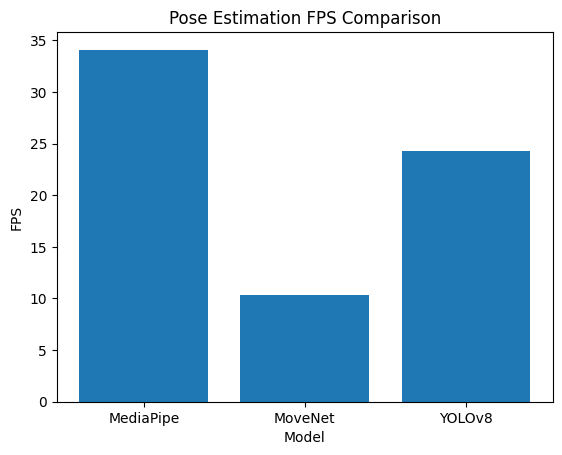

In [139]:
import matplotlib.pyplot as plt
models = ['MediaPipe', 'MoveNet', 'YOLOv8']
fps = [mediapipe_fps, movenet_fps, yolo_fps]
plt.bar(models, fps)
plt.xlabel('Model')
plt.ylabel('FPS')
plt.title('Pose Estimation FPS Comparison')
plt.savefig('fps_comparison.png')

DATASET PROCESSING
python annotator.py videos/MyVideo1.mp4 --output-dir annotations
python extract_keypoints.py

In [68]:
import numpy as np
X = np.load('dataset/X.npy')
y = np.load('dataset/y.npy')
print(X.shape)  # Should be (num_sequences, 30, 99)
print(y.shape)  # Should be (num_sequences,)
print(np.unique(y))  # Should be [0, 1, 2, 3]

# Count samples per class
class_counts = np.bincount(y)
class_names = ['Forehand-GS', 'Backhand-GS', 'Forehand-Volley', 'Backhand-Volley']
for i, count in enumerate(class_counts):
    print(f"Class {i} ({class_names[i]}): {count} samples")

(163, 30, 99)
(163,)
[0 1 2 3]
Class 0 (Forehand-GS): 62 samples
Class 1 (Backhand-GS): 44 samples
Class 2 (Forehand-Volley): 23 samples
Class 3 (Backhand-Volley): 34 samples


In [69]:
visualize_keypoints(X[3], "mediapipe")

In [70]:
# Normalize the data
X = (X - np.mean(X, axis=(1, 2), keepdims=True)) / (np.std(X, axis=(1, 2), keepdims=True) + 1e-8)

In [73]:
# Handle missing keypoints (replace zeros with previous frame)
for i in range(len(X)):
    for t in range(1, X.shape[1]):
        if np.all(X[i, t] == 0):
            X[i, t] = X[i, t-1]

In [75]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, num_classes=4)

In [76]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [77]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (146, 30, 99), y_train shape: (146, 4)
X_test shape: (17, 30, 99), y_test shape: (17, 4)


In [78]:
print("Sample y_train (one-hot):", y_train[:2])
print("X_train min/max:", X_train.min(), X_train.max())

Sample y_train (one-hot): [[          0           0           1           0]
 [          0           0           0           1]]
X_train min/max: -2.523040852921718 2.7113656122318224


In [79]:
print("Sample y_train (one-hot):", y_train[:2])
print("X_train min/max:", X_train.min(), X_train.max())

Sample y_train (one-hot): [[          0           0           1           0]
 [          0           0           0           1]]
X_train min/max: -2.523040852921718 2.7113656122318224


Model

In [100]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, LayerNormalization, Dropout

# actions = np.array(['forehand-gs', 'backhand-gs', 'forehand-volley', 'backhand-volley'])
model = Sequential([
    LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 99), recurrent_dropout=0.0),
    LayerNormalization(axis=1),
    LSTM(128, return_sequences=True, activation='relu'),
    LSTM(128, return_sequences=True, activation='relu'),
    LayerNormalization(axis=1),
    LSTM(64, return_sequences=False, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')  # 4 classes
])

c:\Users\Dulguun\.conda\envs\tf_clean\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [101]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 30, 64)         │        41,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_8           │ (None, 30, 64)         │            60 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 30, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_9           │ (None, 30, 128)        │            60 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 328,284 (1.25 MB)

 Trainable params: 328,284 (1.25 MB)

 Non-trainable params: 0 (0.00 B)

In [102]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

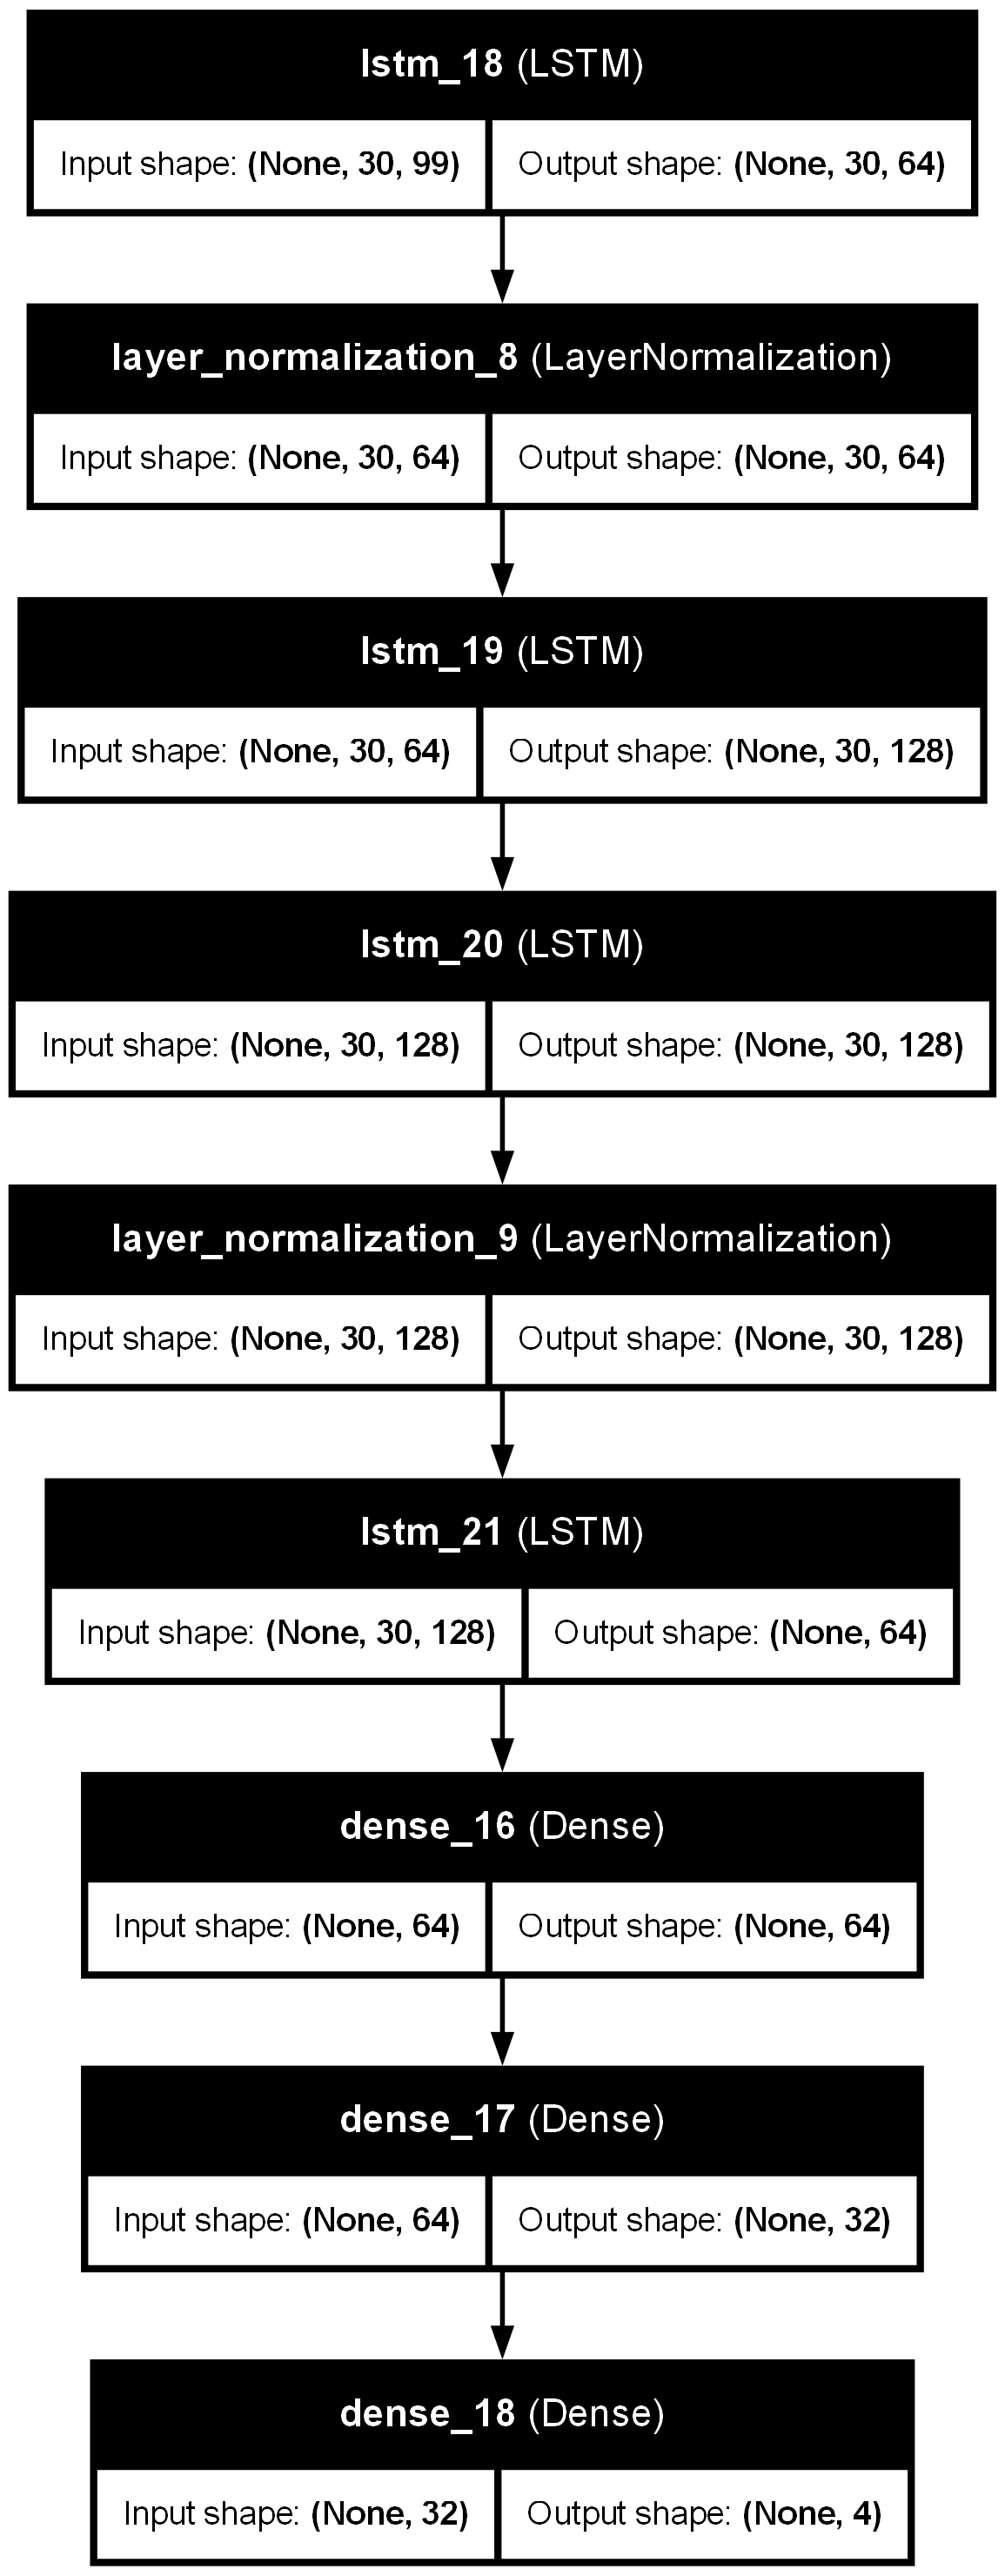

In [103]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [104]:
history = model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=16,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.3044 - loss: 1.3134 - val_accuracy: 0.4118 - val_loss: 1.0877
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5771 - loss: 0.9860 - val_accuracy: 0.6471 - val_loss: 0.9320
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7458 - loss: 0.8046 - val_accuracy: 0.5882 - val_loss: 0.7998
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7724 - loss: 0.5885 - val_accuracy: 0.5294 - val_loss: 0.8509
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7327 - loss: 0.5893 - val_accuracy: 0.5882 - val_loss: 0.8252
Epoch 6/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6982 - loss: 0.5950 - val_accuracy: 0.5882 - val_loss: 0.6967
Epoch 7/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7575 - loss: 0.6029 - val_accuracy: 0.5882 - val_loss: 0.7932
Epoch 8/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7409 - loss: 0.5689 - val_accuracy: 0.

In [105]:
# Evaluate model
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Train accuracy: {train_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

Train accuracy: 1.0000
Test accuracy: 0.5294


In [106]:

model.save('tennismodel_final.h5')  # creates a HDF5 file
print("Model saved to tennismodel_final.h5")

Model saved to tennismodel_final.h5


Text(0.5, 1.0, 'Нарийвчлалын График')

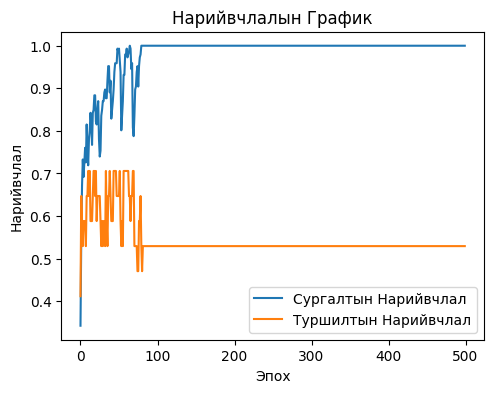

In [107]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Сургалтын Нарийвчлал')
plt.plot(history.history['val_accuracy'], label='Туршилтын Нарийвчлал')
plt.xlabel('Эпох')
plt.ylabel('Нарийвчлал')
plt.legend()
plt.title('Нарийвчлалын График')

Text(0.5, 1.0, 'Алдагдлын График')

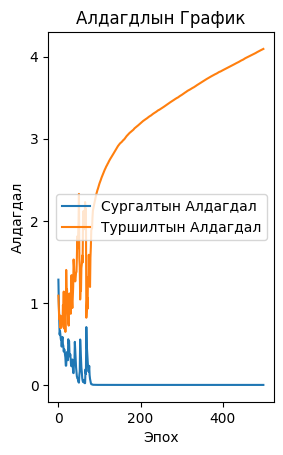

In [108]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Сургалтын Алдагдал')
plt.plot(history.history['val_loss'], label='Туршилтын Алдагдал')
plt.xlabel('Эпох')
plt.ylabel('Алдагдал')
plt.legend()
plt.title('Алдагдлын График')

In [109]:
plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

<Figure size 640x480 with 0 Axes>

In [110]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_classes, y_pred_classes)
print("Confusion Matrix:")
print(cm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
Confusion Matrix:
[[4 1 1 0]
 [0 3 0 2]
 [2 0 0 0]
 [0 2 0 2]]


In [140]:
import cv2
import mediapipe as mp
import numpy as np
import tensorflow as tf
from pathlib import Path
import os

# Suppress TensorFlow warnings
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = None
try:
    pose = mp_pose.Pose(static_image_mode=False, model_complexity=0, min_detection_confidence=0.5)
    print("MediaPipe Pose initialized successfully with model_complexity=0.")
except Exception as e:
    print(f"Failed to initialize MediaPipe Pose: {e}")
    raise

# Class names
class_names = ['Forehand-GS', 'Backhand-GS', 'Forehand-Volley', 'Backhand-Volley']

def preprocess_sequence(sequence):
    """
    Preprocess a single 30-frame keypoint sequence to match training data.
    """
    # Normalize (mean=0, std=1)
    sequence = (sequence - np.mean(sequence, axis=(0, 1), keepdims=True)) / (np.std(sequence, axis=(0, 1), keepdims=True) + 1e-8)
    
    # Handle missing keypoints (replace zeros with previous frame)
    for t in range(1, sequence.shape[0]):
        if np.all(sequence[t] == 0):
            sequence[t] = sequence[t-1]
    
    return sequence

def extract_keypoints_from_video(video_path, frame_indices=None, sequence_length=30, stride=10):
    """
    Extract 30-frame keypoint sequences from a video.
    If frame_indices is provided, extract sequences around those frames.
    Otherwise, use a sliding window with given stride.
    """
    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Error: Could not open video {video_path}")
            return None, None, None

        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        print(f"Video properties: {frame_width}x{frame_height}, {fps} FPS, {total_frames} frames")

        sequences = []
        sequence_centers = []

        if frame_indices is None:
            # Sliding window approach
            frame_indices = range(sequence_length // 2, total_frames - sequence_length // 2, stride)
        else:
            # Filter valid frame indices
            frame_indices = [f for f in frame_indices if sequence_length // 2 <= f < total_frames - sequence_length // 2]
            print(f"Using {len(frame_indices)} annotated frame indices")

        for center_frame in frame_indices:
            start_frame = max(0, center_frame - sequence_length // 2)
            end_frame = start_frame + sequence_length
            cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

            keypoints_sequence = []
            frame_count = start_frame

            while frame_count < end_frame:
                ret, frame = cap.read()
                if not ret:
                    print(f"Warning: Failed to read frame {frame_count}")
                    break

                # Process frame
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                results = pose.process(frame_rgb)

                keypoints = []
                if results.pose_landmarks:
                    for landmark in results.pose_landmarks.landmark:
                        keypoints.extend([landmark.x, landmark.y, landmark.visibility])
                else:
                    keypoints = [0] * 99  # 33 landmarks * 3 (x, y, visibility)

                keypoints_sequence.append(keypoints)
                frame_count += 1

            if len(keypoints_sequence) == sequence_length:
                sequences.append(preprocess_sequence(np.array(keypoints_sequence)))
                sequence_centers.append(center_frame)
            else:
                print(f"Warning: Incomplete sequence at center frame {center_frame} (got {len(keypoints_sequence)} frames)")

        cap.release()
        return np.array(sequences), sequence_centers, fps

    except Exception as e:
        print(f"Error in extract_keypoints_from_video: {e}")
        cap.release()
        return None, None, None

def test_model_on_video(video_path, model_path, annotation_csv=None, output_video=None, display_duration=1.0):
    """
    Test the LSTM model on a video and optionally save output with predictions.
    Text labels are displayed for display_duration seconds.
    """
    try:
        # Load model
        model = tf.keras.models.load_model(model_path)
        print(f"Loaded model from {model_path}")

        # Load annotations if provided
        frame_indices = None
        if annotation_csv and os.path.exists(annotation_csv):
            import pandas as pd
            df = pd.read_csv(annotation_csv)
            frame_indices = df['FrameId'].values
            print(f"Loaded {len(frame_indices)} annotated frames from {annotation_csv}")

        # Extract sequences
        sequences, sequence_centers, fps = extract_keypoints_from_video(video_path, frame_indices)
        if sequences is None or len(sequences) == 0:
            print("No valid sequences extracted")
            return

        # Predict
        print("Running model predictions...")
        predictions = model.predict(sequences, verbose=0)
        predicted_classes = np.argmax(predictions, axis=1)
        confidences = np.max(predictions, axis=1)

        # Print predictions
        for i, (center, pred, conf) in enumerate(zip(sequence_centers, predicted_classes, confidences)):
            print(f"Frame {center}: {class_names[pred]} (Confidence: {conf:.2f})")

        # Visualize predictions on video (if output_video is specified)
        if output_video:
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print(f"Error: Could not open video {video_path} for visualization")
                return

            frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            out = cv2.VideoWriter(output_video, fourcc, fps, (frame_width, frame_height))
            if not out.isOpened():
                print(f"Error: Could not create output video {output_video}")
                cap.release()
                return

            # Calculate display frames
            display_frames = int(fps * display_duration)
            display_ranges = [(max(0, c - display_frames // 2), c + display_frames // 2) for c in sequence_centers]

            frame_idx = 0
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break

                # Find the most recent prediction within display range
                label = None
                for i, (start, end) in enumerate(display_ranges):
                    if start <= frame_idx <= end:
                        label = f"{class_names[predicted_classes[i]]} ({confidences[i]:.2f})"
                        break

                # Draw keypoints
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                results = pose.process(frame_rgb)
                if results.pose_landmarks:
                    mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

                # Draw label if available
                if label:
                    cv2.putText(frame, label, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

                out.write(frame)
                frame_idx += 1

            cap.release()
            out.release()
            print(f"Output video saved to {output_video}")

    except Exception as e:
        print(f"Error in test_model_on_video: {e}")
    finally:
        if pose is not None:
            pose.close()
            print("MediaPipe Pose closed.")

MediaPipe Pose initialized successfully with model_complexity=0.


In [141]:
# Run the test
video_path = 'videos/test2.mp4'  # Replace with your video path
model_path = 'tennismodel_final.h5'
annotation_csv = 'annotations/annotation_test2.csv'  # Optional, set to None if no annotations
output_video = 'output_test2.mp4'  # Optional, set to None to skip video output
display_duration = 0.5  # Text display duration in seconds

os.makedirs("output", exist_ok=True)

# Verify video exists
if not os.path.exists(video_path):
    print(f"Error: Video file {video_path} not found.")
else:
    test_model_on_video(video_path, model_path, annotation_csv, output_video, display_duration=1.0)

Loaded model from tennismodel_final.h5
Loaded 4 annotated frames from annotations/annotation_test2.csv
Video properties: 640x360, 29 FPS, 296 frames
Using 4 annotated frame indices
Running model predictions...
Frame 30: Forehand-GS (Confidence: 1.00)
Frame 104: Backhand-GS (Confidence: 1.00)
Frame 172: Forehand-GS (Confidence: 1.00)
Frame 257: Forehand-Volley (Confidence: 1.00)
Output video saved to output_test2.mp4
MediaPipe Pose closed.
